# Chicago crimes with tensorflow

In this project I will use the chicago crime dataset to skill up in Tensorflow. The idea is to predict if a given crime will lead to an arrest or not. 

Let's start by importing the relevant packages

In [1]:
import os
import matplotlib
import numpy
import pandas
import seaborn
import tensorflow.keras as keras

## Importing data
First, let's import a subset of the data in a .csv file via pandas and make some exploratory analysis. This way I can  get a first understanding of the kind of pre-processing I need for the data.

In [2]:
file_name = 'Crimes_-_2020.csv'
file_source_path = os.path.join(os.getcwd(), file_name)
chicago_crime_dataset = pandas.read_csv(file_source_path)

First of all, let's inspect a few entries of the dataset and the data types

In [3]:
chicago_crime_dataset.head(5)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,12226684,JD437696,11/21/2020 10:24:00 AM,048XX W IRVING PARK RD,1330,CRIMINAL TRESPASS,TO LAND,SMALL RETAIL STORE,False,False,...,45.0,15,26,NaN,NaN,2020,11/28/2020 03:46:29 PM,NaN,NaN,NaN
1,12227040,JD437515,11/21/2020 05:25:00 AM,060XX S KOMENSKY AVE,033A,ROBBERY,ATTEMPT ARMED - HANDGUN,RESIDENCE - GARAGE,False,False,...,23.0,65,03,NaN,NaN,2020,11/28/2020 03:46:29 PM,NaN,NaN,NaN
2,12227432,JD438595,11/21/2020 09:30:00 PM,001XX E 117TH PL,1562,SEX OFFENSE,AGGRAVATED CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,9.0,53,17,NaN,NaN,2020,11/28/2020 03:46:29 PM,NaN,NaN,NaN
3,12228918,JD439369,11/21/2020 05:00:00 PM,007XX E 81ST ST,0930,MOTOR VEHICLE THEFT,THEFT / RECOVERY - AUTOMOBILE,STREET,False,False,...,6.0,44,07,NaN,NaN,2020,11/28/2020 03:46:29 PM,NaN,NaN,NaN
4,12231193,JD443060,10/16/2020 12:00:00 PM,060XX W MIAMI AVE,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,RESIDENCE,False,False,...,39.0,10,11,NaN,NaN,2020,11/28/2020 03:46:29 PM,NaN,NaN,NaN


In [4]:
chicago_crime_dataset.dtypes

ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                    float64
Community Area            int64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object

This shows immediately some anomalies that do not make sense according to the type of data I expect. In particular:
1. Case number and Block are misnamed. Case number is an alphanumeric identifier, while Block is the address.
2. Date and Updated on are date objects and not strings. Moreover, the format is non-standard.
3. ID, Beat, District, Wards and Community areas are identification codes, not numbers.
4. Year is redundant. It's also not particularly interesting because this dataset covers 2020 only.
5. Location is redundant, at least for the specific purpoeses of this project. Furthermore, I checked that entries with missing values of XY coordinates do not have entries of latitude-longitude coordinates. The analysis is not shown here, but it can be performed with chicago_crime_dataset.loc[chicago_crime_dataset['Longitude'].isna(), ['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude']].head(10).sum()

For the moment I will correct point 2 to 5 only because I will need to stick with the original column namings when I will play around with tensorflow later on.




In [5]:
# recast dates in correct iso formats
date_format = '%m/%d/%Y %I:%M:%S %p'
chicago_crime_dataset['Date'] = pandas.to_datetime(chicago_crime_dataset['Date'], format = date_format).head()
chicago_crime_dataset['Updated On'] = pandas.to_datetime(chicago_crime_dataset['Updated On'], format = date_format).head()

# recast faux integers as string identifiers
int_to_str_conversions = {'ID' : 'str',
                          'Beat' : 'str',
                          'District' : 'str',
                          'Ward' : 'str',
                          'Community Area' : 'str'}
chicago_crime_dataset = chicago_crime_dataset.astype(int_to_str_conversions)

# drop redundant columns
chicago_crime_dataset.pop('Year')
chicago_crime_dataset.pop('Location')
chicago_crime_dataset.pop('Longitude')
chicago_crime_dataset.pop('Latitude')

# show new data structure
chicago_crime_dataset.dtypes

ID                              object
Case Number                     object
Date                    datetime64[ns]
Block                           object
IUCR                            object
Primary Type                    object
Description                     object
Location Description            object
Arrest                            bool
Domestic                          bool
Beat                            object
District                        object
Ward                            object
Community Area                  object
FBI Code                        object
X Coordinate                   float64
Y Coordinate                   float64
Updated On              datetime64[ns]
dtype: object

I might need more adjustmens later on, but let's be happy with it for now.  As safety check, let's also count the number of nans to get an idea of how much information is missing

In [6]:
# isolate columns with nans, and count the nans
nans_count = chicago_crime_dataset.isna().sum()
columns_with_nans = nans_count[nans_count > 0]

# inspect missing not at random by counting nans from rows where Date is missing
missing_not_at_random = chicago_crime_dataset.loc[chicago_crime_dataset['Date'].isna(), columns_with_nans.index].isna().sum()

print('Rows with nans:')
print(columns_with_nans)
print(' ')
print('Rows with nans on rows that have a missing Date')
print(missing_not_at_random)

Rows with nans:
Date                    187640
Location Description       996
X Coordinate             23551
Y Coordinate             23551
Updated On              187640
dtype: int64
 
Rows with nans on rows that have a missing Date
Date                    187640
Location Description       996
X Coordinate             23546
Y Coordinate             23546
Updated On              187640
dtype: int64


There are a few things to keep in mind:
1. A relatively large number of cases do not have a Date. The number of cases without also coindiced with the number of cases without an update
2. Rows with missing Date can also have missing Coordinates, Location description and Updated On. I wonder if this arise because of some information embargo.



Let's now describe the dataframe content. The only continuous variables left are the XY coordinates.

<AxesSubplot:xlabel='X Coordinate', ylabel='Y Coordinate'>

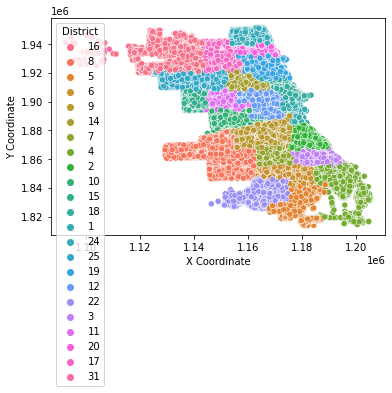

In [7]:
# quick overview of continuous variables
seaborn.scatterplot(x = 'X Coordinate', 
                    y = 'Y Coordinate',
                    hue = 'District', 
                    data = chicago_crime_dataset)

These data distributes according to the shape of Chicago. District, Beats and similar are spatially connected in a meaningful way (plot shown only for Districts). 

Speaking instead of cateforical variables:

In [8]:
# Quick overview of categorical variables
chicago_crime_dataset.astype('object').describe()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Updated On
count,187645,187645,5,187645,187645,187645,187645,186649,187645,187645,187645,187645,187645,187645,187645,164094.0,164094.0,5
unique,187645,187618,5,26314,308,33,414,163,2,2,274,23,51,77,26,44415.0,58848.0,1
top,12004212,JD286197,2020-11-21 05:25:00,001XX N STATE ST,0486,BATTERY,SIMPLE,STREET,False,False,1834,11,28.0,25,06,1176352.0,1900927.0,2020-11-28 15:46:29
freq,1,4,1,450,18643,37846,21111,45393,157760,152262,1710,13337,9609,11338,37077,267.0,203.0,5


In [9]:
# inspect structure of cases with multiple crime IDs in it.
cases_with_multiple_IDs = chicago_crime_dataset.loc[chicago_crime_dataset\
                                                .duplicated(subset = 'Case Number', keep = False)]\
                                                .sort_values('Case Number')
cases_with_multiple_IDs.astype('object').describe()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Updated On
count,51,51,0,51,51,51,51,51,51,51,51,51,51,51,51,51.0,51.0,0
unique,51,24,0,24,1,1,1,7,2,2,22,12,16,19,1,24.0,24.0,0
top,25282,JD286197,NaN,061XX S CARPENTER ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,712,4,7.0,46,01A,1170368.0,1864018.0,NaN
freq,1,4,NaN,4,51,51,51,25,32,44,4,14,10,6,51,4.0,4.0,NaN


The behavior of categorical observables require a little more care. Specifically, one can observe that:
1. In general, all entries tend to have an unique ID and unique Case Number with an exceptions. A bunch of homicide entries have the same Case Number but multiple ID and redacted Date (see cell below). I believe that these cases involve multiple homicides under information embargo, but I have no way to check it.
2. There are data only for 5 dates in this dataset. This is not surprising because the .csv file with the data is just a subsample of the total dataset. I need to remember this for further developments.

in general I would produce histograms that counts the categorical variables at this point. However, the sheer size of the dataset, and the number of categories in the categorical variables make this unfeasible.

I will recover this part later on with bigquery and its ability to aggregate from the Cloud. For the moment I will count only the 'Arrest' column because this is the label I want to predict. 


<AxesSubplot:xlabel='Arrest', ylabel='count'>

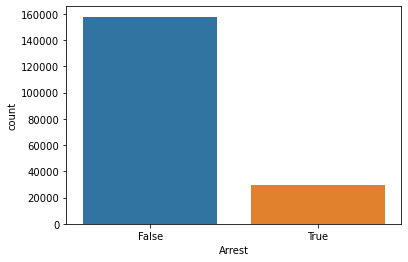

In [10]:
seaborn.countplot(x = chicago_crime_dataset['Arrest'])

The Arrest thus have a strong bias towars crimes that do not lead to an arrest. Well, this is reasonable given that many crimes correspond to minor offences for which arrests do not make sense.

# Building the predictive model
W